In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar as c
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.iolib.summary2 import summary_col
import matplotlib.ticker as mtick
from linearmodels.panel.model import FamaMacBeth
import warnings
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Cleaning Data

In [2]:
def factor_regression(x_vals):
    results =[]
    X = monthly[x_vals]
    X = sm.add_constant(X) 
    for i in ["hml", "umd", "rmw", "cma", "bab"]:
        results.append(sm.OLS(monthly[i], X, missing='drop').fit())

    info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
               'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results= results,
                                float_format='%0.3f',
                                stars = True,
                                info_dict=info_dict)
    print(results_table)

In [3]:
def quintile_regression(x_vals, estimate, deciles=False):
    results =[]
    X = monthly[x_vals]
    X = sm.add_constant(X)
    
    
    if(deciles==True):
        for i in [1,2,3,4,5,6,7,8,9,10, estimate]:
            results.append(sm.OLS(monthly[i], X, missing='drop').fit())

        info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
               'No. observations' : lambda x: f"{int(x.nobs):d}"}

        results_table = summary_col(results= results,
                                float_format='%0.3f',
                                stars = True,
                                model_names = ["Q1", "Q2", "Q3", "Q4", "Q5","Q6", "Q7", "Q8", "Q9", "Q10", estimate],
                                info_dict=info_dict)
        print(results_table)

    else:
        
        for i in [1,2,3,4,5, estimate]:
            results.append(sm.OLS(monthly[i], X, missing='drop').fit())

        info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
                   'No. observations' : lambda x: f"{int(x.nobs):d}"}

        results_table = summary_col(results= results,
                                    float_format='%0.3f',
                                    stars = True,
                                    model_names = ["Q1", "Q2", "Q3", "Q4", "Q5", estimate],
                                    info_dict=info_dict)
        print(results_table)

In [4]:
def SloanDuration(data, ROE_coef, Earnings_coef, ROE_intercept, Earnings_intercept, start_date=17):
    subset= data.copy()
    T = 15
    perpetuity_duration = T + (1.+ROE_intercept)/ROE_intercept
  
    #cross_section = pd.DataFrame(index=[date_index[j]], columns = tickers)
    duration=[]

    for j in range(start_date, data[0].shape[0]):
        
        for i in range(len(subset)):
            subset[i] = data[i].iloc[:j,:] 
        
        cross_section = pd.DataFrame(index=[date_index[j]], columns = tickers)
        for i in subset:    
            ROE_growth =  [i["ROE"][-1]]
            EG_growth =  [i["SG"][-1]]
            BV=  [i["be"][-1]]
            E =  [i["ib"][-1]]
            PVCF = []
            PVCF_t = []
            for k in range(T):
                ROE_growth.append(ROE_intercept*(1.-ROE_coef)+ROE_growth[-1]*ROE_coef)
                EG_growth.append(Earnings_intercept*(1.- Earnings_coef)+EG_growth[-1]*Earnings_coef)
                BV.append((EG_growth[-1]*BV[-1]) + BV[-1])
                E.append(ROE_growth[-1]*BV[-2])
                PVCF.append((E[-1] - (BV[-1] - BV[-2]))/(1. + ROE_intercept)**(k+1))
                PVCF_t.append(PVCF[-1]*(k+1))

            finite_duration = np.asarray(PVCF_t).sum()/np.asarray(PVCF).sum()
            weight = np.asarray(PVCF).sum()/i["me"][-1]
            implied_duration = weight*finite_duration +(1. - weight)*perpetuity_duration
            try:
                cross_section[i["tic"].dropna().unique()[0]] = implied_duration
            except IndexError: #cross_section only contains nans
                continue
                
        duration.append(cross_section)
    duration = pd.concat(duration)
    #duration.to_csv("WeberDuration.csv")
    return duration

In [5]:
def Weber_regression(x_vals, estimate, deciles=False):
    results =[]
    X = monthly[x_vals]
    X = sm.add_constant(X)

    for i in [1,2,3,4,5, estimate]:
        results.append(sm.OLS(quintile_monthly[i], X, missing='drop').fit())

    info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results= results,
                            float_format='%0.3f',
                            stars = True,
                            model_names = ["Q1", "Q2", "Q3", "Q4", "Q5", estimate],
                            info_dict=info_dict)
    print(results_table)

In [6]:
def EarningsToPriceEstimator(data, ROE_coef, Earnings_coef, ROE_intercept, Earnings_intercept, start_date=17):
    subset= data.copy()
    T = 15.
    r = ROE_intercept
    perpetuity_duration = T + (1.+ROE_intercept)/ROE_intercept
  
    duration=[]
    for j in range(start_date, data[0].shape[0]):
                    
        for i in range(len(subset)):
            subset[i] = data[i].iloc[:j,:] 
            
        cross_section = pd.DataFrame(index=[date_index[j]], columns = tickers)
        for i in subset:
            i["ib"][i["ib"]<0.] = np.nan
            finite_duration = - i["ib"][-1]/i["me"][-1]*(T/ROE_intercept)
            implied_duration = perpetuity_duration + finite_duration
            try:
                cross_section[i["tic"].dropna().unique()[0]] = implied_duration
            except IndexError:
                continue
        
        cross_section = cross_section.astype(float)
        #cross_section[cross_section>100.]=100.
        duration.append(cross_section)

    duration = pd.concat(duration)
    return duration

In [7]:
def quintile_regression_Latex(x_vals, estimate, deciles=False):
    results =[]
    X = monthly[x_vals]
    X = sm.add_constant(X)
    
    
    if(deciles==True):
        for i in [1,2,3,4,5,6,7,8,9,10, estimate]:
            results.append(sm.OLS(monthly[i], X, missing='drop').fit())

        info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
               'No. observations' : lambda x: f"{int(x.nobs):d}"}

        results_table = summary_col(results= results,
                                float_format='%0.3f',
                                stars = True,
                                model_names = ["Q1", "Q2", "Q3", "Q4", "Q5","Q6", "Q7", "Q8", "Q9", "Q10", estimate],
                                info_dict=info_dict)
        print(results_table)

    else:
        
        for i in [1,2,3,4,5, estimate]:
            results.append(sm.OLS(monthly[i], X, missing='drop').fit())

        info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
                   'No. observations' : lambda x: f"{int(x.nobs):d}"}

        results_table = summary_col(results= results,
                                    float_format='%0.3f',
                                    stars = True,
                                    model_names = ["Q1", "Q2", "Q3", "Q4", "Q5", estimate],
                                    info_dict=info_dict)
        print(results_table.as_latex())

In [64]:
def LSfactor9(factor, daily_returns= monthly_returns):
    signal = factor.dropna(how='all', axis=[0, 1])
    signal = signal.clip(lower=signal.quantile(0.01, axis=1), upper=signal.quantile(0.99, axis=1), axis=0)
    quintiles = signal.apply(lambda x: pd.qcut(x, 9, labels=range(9, 0, -1)), axis=1)
    quintiles = quintiles.reindex(daily_returns.index, method = "nearest")
    quintile_weights = dict()
    for q in range(1,10):
        q_weights = (quintiles == q).astype(int)
        q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
        quintile_weights[q] = q_weights
    quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])
    value_10 = quintile_weights.mul(daily_returns, axis=0, level=1).sum(axis=1, level=0)
    
    return 0.5*(value_10[1] + value_10[2] - value_10[8] - value_10[9])

In [65]:
def doubleSortFactor(first_sort, second_sort, daily_returns= monthly_returns):
    signal = first_sort.dropna(how='all', axis=[0, 1])
    signal = signal.clip(lower=signal.quantile(0.01, axis=1), upper=signal.quantile(0.99, axis=1), axis=0)
    value_split = signal.apply(lambda x: pd.qcut(x, 3, labels=range(3, 0, -1)), axis=1)

    high_val = value_split.where(value_split==1.)
    mid_val = value_split.where(value_split==2.)/2.
    low_val = value_split.where(value_split==3.)/3.
    high_val = high_val.mul(second_sort).dropna(how='all', axis=[0, 1]).apply(lambda x: pd.qcut(x, 3, labels=[3,2,1]), axis=1)
    mid_val = mid_val.mul(second_sort).dropna(how='all', axis=[0, 1]).apply(lambda x: pd.qcut(x, 3, labels=[6,5,4]), axis=1)
    low_val = low_val.mul(second_sort).dropna(how='all', axis=[0, 1]).apply(lambda x: pd.qcut(x, 3, labels=[9,8,7]), axis=1)
    sorted_stocks = low_val.fillna(mid_val)
    sorted_stocks = sorted_stocks.fillna(high_val)
    sorted_stocks = sorted_stocks.reindex(daily_returns.index, method = "nearest")

    quintile_weights = dict()
    for q in range(1,10):
        q_weights = (sorted_stocks == q).astype(int)
        q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
        quintile_weights[q] = q_weights
    quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])
    duration_2_value_5 = quintile_weights.mul(daily_returns, axis=0, level=1).sum(axis=1, level=0)
    
    return(0.5*(duration_2_value_5[1] + duration_2_value_5[7] - duration_2_value_5[3] - duration_2_value_5[9]))

In [66]:
def FamaMacBeth_NPeriod(daily_returns, factors, N=1, GLS=False, NW = False):
    
    daily_returns = daily_returns.resample('M').sum().dropna(how='all', axis=[0, 1])
    cols = daily_returns.columns
    
    factors = factors.resample('M').sum().dropna(how='all', axis=[0, 1])
    factors = factors.reindex(daily_returns.index, method="nearest")
    step = int(factors.shape[0]/N)
    factors["intercept"] = np.ones(factors.shape[0])
    index = factors.columns    
    
    results = []
    for i in range(1,N+1):
        
        #First pass regression
        Y = np.asmatrix(daily_returns.iloc[(i-1)*step:i*step,:].dropna(how='all', axis=[0, 1]))
        X = np.asmatrix(factors.iloc[(i-1)*step:i*step,:].dropna(how='all', axis=[0, 1]))
        regression1 = pd.DataFrame(np.linalg.pinv(X.T.dot(X)).dot(X.T.dot(Y)), index = index, columns=cols)

        #Second pass regression
        if GLS:
            X = regression1.iloc[:-1,:].T
            X["intercept"] = np.ones(X.shape[0])
            cov = np.asmatrix(X.T.cov())
            X = np.asmatrix(X)
            regression2 = pd.DataFrame(np.linalg.pinv(X.T.dot(np.linalg.pinv(cov)).dot(X)).dot(X.T.dot(np.linalg.pinv(cov)).dot(Y.T)), index= index)
                        
        else:     
            X = regression1.iloc[:-1,:].T
            X["intercept"] = np.ones(X.shape[0])
            X = np.asmatrix(X)
            regression2 = pd.DataFrame(np.linalg.pinv(X.T.dot(X)).dot(X.T.dot(Y.T)), index= index)
        
        mean = regression2.mean(axis=1)
        se = regression2.std(axis=1) / (regression2.shape[1])**0.5
        if NW:
            regression2 = regression2.T
            correction = []
            for i in regression2.columns[:-1]:
                regression2[i].autocorr()
                n = 48
                NW = 1.
                for i in range(n):
                    NW += (1 - i/(n+1))*0.05**i
                correction.append(NW)
            correction.append(1.)
            se = se*np.sqrt(correction)
            
        t_stat = np.round(mean / se , 2)
        mean = np.round(mean*1200,2)
        #mean["start date"] = daily_returns.index[(i-1)*step]
        #t_stat["end date"] = daily_returns.index[i*step -1]

        results.append(pd.DataFrame((mean, t_stat), index=['Risk Premium', 't']))
    return pd.concat(results)

In [28]:
daily_returns = pd.read_csv("SurvivorshipCompustat.csv", index_col=2)
del daily_returns["gvkey"]
del daily_returns["iid"]

daily_returns = daily_returns[daily_returns["prccm"]>5.]
daily_returns["MC"] = daily_returns["prccm"].mul(daily_returns["cshom"])
daily_returns = daily_returns[daily_returns["MC"]>1e9].dropna(how='all', axis=[0, 1])

In [29]:
daily_returns.to_csv("returns.csv")

In [10]:
returns = pd.read_csv("returns.csv", index_col=0)
returns.index = pd.to_datetime(returns.index)
returns = returns.drop_duplicates()

In [11]:
grouped_sectors = returns.groupby('gind')

In [338]:
test = pd.DataFrame(columns=returns["tic"].unique(), index=returns.index.unique().sort_values())

In [339]:
for i in test.columns:
    try:
        test[i] = returns["MC"].where(returns["tic"] == i).dropna()/100.

    except ValueError: #Not enough observations
        continue

In [341]:
monthly_returns = test.dropna(how='all', axis=[0, 1])
monthly_returns.to_csv("CompustatMonthlyMC.csv")

# Bond-Beta

In [12]:
monthly_returns = pd.read_csv("CompustatMonthlyReturns.csv", index_col=0)
market_cap = pd.read_csv("CompustatMonthlyMC.csv", index_col=0)
monthly_returns.index = pd.to_datetime(monthly_returns.index)
market_cap.index = pd.to_datetime(market_cap.index)
monthly_returns[monthly_returns>2.] = 2.

quintiles = market_cap.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
quintiles = quintiles[quintiles<4.]
quintiles[quintiles>0.] = 1.
market_cap = market_cap.mul(quintiles)
market_cap = market_cap.dropna(how='all', axis=[0, 1]).ffill(limit=3)

monthly_returns = monthly_returns[market_cap.columns.intersection(monthly_returns.columns)]
monthly_returns = monthly_returns.reindex(market_cap.index, method = "pad")

In [13]:
rates = pd.read_csv("rates_data.csv", index_col=0)
rates.index = pd.to_datetime(rates.index)
rates = rates.dropna(how='all', axis=[0, 1])
rates = rates.pct_change().dropna(how='all', axis=[0, 1])
rates = rates.resample("M").sum()
rates = rates.reindex(monthly_returns.index, method="pad")

In [14]:
monthly_returns = pd.concat((monthly_returns,rates['US1 Comdty']), axis=1, join='inner')

factors = pd.read_csv("factors.csv", index_col=0)
factors.index = pd.to_datetime(factors.index)
factors = factors.resample("M").sum()
factors = factors.reindex(monthly_returns.index, method = "pad")
market = factors["mktrf"]

In [15]:
ty_betas = pd.DataFrame(index=monthly_returns.index, columns= monthly_returns.columns[:-1])
minimum = 36

for i in ty_betas.columns:

    ty_betas[i] = (monthly_returns[i].rolling(60, min_periods=minimum).cov(monthly_returns['US1 Comdty'], pairwise = True)*market.rolling(60, min_periods=minimum).std()**2 - 
                   monthly_returns['US1 Comdty'].rolling(60, min_periods=minimum).cov(market, pairwise = True)*monthly_returns[i].rolling(60, min_periods=minimum).cov(market, pairwise = True)**2)/(market.rolling(60, min_periods=minimum).std()**2*monthly_returns['US1 Comdty'].rolling(60, min_periods=minimum).std()**2 - monthly_returns['US1 Comdty'].rolling(60, min_periods=minimum).cov(market, pairwise = True)**2)


In [16]:
betas_temp = ty_betas

#betas_temp = ty_betas.iloc[:115]
#betas_temp = ty_betas.iloc[145:]

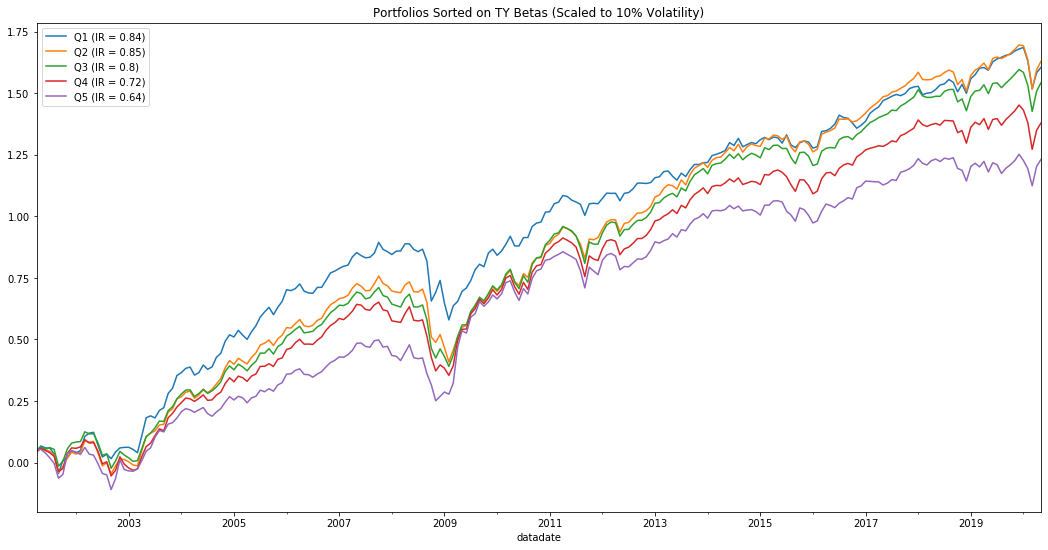

In [17]:
signal = betas_temp.dropna(how='all', axis=[0, 1])
signal = signal.clip(lower=signal.quantile(0.01, axis=1), upper=signal.quantile(0.99, axis=1), axis=0)
quintiles = signal.apply(lambda x: pd.qcut(x.rank(method='first'), 5, labels=range(5, 0, -1)), axis=1)
monthly_returns = monthly_returns.reindex(quintiles.index, method="pad")

quintile_weights = dict()
for q in range(1, 6):
    q_weights = (quintiles == q).astype(int)
    q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
    quintile_weights[q] = q_weights
quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])


quintile_returns = quintile_weights.mul(monthly_returns[signal.columns], axis=0, level=1).sum(axis=1, level=0, min_count=1)
quintile_returns = quintile_returns * (0.10 / (12**0.5 * quintile_returns.std()))
quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])
quintile_returns = quintile_returns * (0.10 / (12**0.5 * quintile_returns.std()))

df = quintile_returns.drop('duration', axis=1)
df.columns = ['Q{i} (IR = {ir})'.format(i=i, ir=np.round(12**0.5 * df[i].mean() / df[i].std(),2)) for i in df.columns]
df.cumsum().plot(title='Portfolios Sorted on TY Betas (Scaled to 10% Volatility)',
                 figsize=(18, 9));

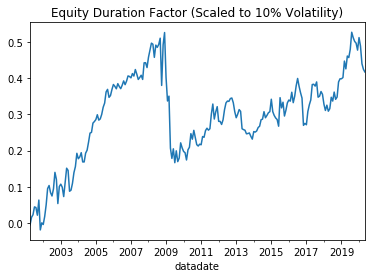

In [18]:
duration = quintile_returns['duration']
duration.cumsum().plot(title='Equity Duration Factor (Scaled to 10% Volatility)');

In [19]:
quintile_returns = quintile_weights.mul(monthly_returns[signal.columns], axis=0, level=1).sum(axis=1, level=0, min_count=1)*12
quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])

factors = pd.read_csv("factors.csv", index_col=0)
factors.index = pd.to_datetime(factors.index)
del factors["rf"]
del factors["mktrf"]
factors = factors.resample("M").sum()*12
factors = factors.reindex(quintile_returns.index, method = "pad")
market = monthly_returns[signal.columns].mean(axis=1)
factors["mktrf"] = market*12

factors = pd.concat((factors,quintile_returns), axis=1, join='inner')
cols = list(factors)
cols.insert(0, cols.pop(cols.index('duration')))
factors = factors.ix[:, cols]

In [20]:
monthly = factors#.resample('M').sum()*12
corr = round(monthly.corr(),3)
corr.style.background_gradient()

,duration,smb,hml,umd,rmw,cma,bab,mktrf,1,2,3,4,5
duration,1,-0.245,-0.097,0.475,0.373,0.169,0.404,-0.465,0.047,-0.274,-0.455,-0.594,-0.772
smb,-0.245,1,0.032,-0.112,-0.278,-0.074,-0.12,0.373,0.286,0.316,0.351,0.367,0.379
hml,-0.097,0.032,1,-0.192,-0.112,0.416,0.038,0.134,0.073,0.129,0.147,0.159,0.124
umd,0.475,-0.112,-0.192,1,0.385,0.247,0.496,-0.468,-0.289,-0.379,-0.431,-0.471,-0.565
rmw,0.373,-0.278,-0.112,0.385,1,0.153,0.476,-0.396,-0.26,-0.332,-0.38,-0.413,-0.464
cma,0.169,-0.074,0.416,0.247,0.153,1,0.154,-0.326,-0.278,-0.275,-0.266,-0.269,-0.312
bab,0.404,-0.12,0.038,0.496,0.476,0.154,1,-0.234,-0.077,-0.152,-0.211,-0.271,-0.373
mktrf,-0.465,0.373,0.134,-0.468,-0.396,-0.326,-0.234,1,0.854,0.967,0.987,0.977,0.917
1,0.047,0.286,0.073,-0.289,-0.26,-0.278,-0.077,0.854,1,0.923,0.839,0.75,0.599
2,-0.274,0.316,0.129,-0.379,-0.332,-0.275,-0.152,0.967,0.923,1,0.972,0.924,0.808


In [21]:
quintile_regression_Latex(x_vals=["mktrf", "smb", "hml", "cma", "rmw" ], estimate="duration")

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                 &    Q1    &     Q2    &     Q3    &     Q4    &     Q5    &  duration  \\
\midrule
const            & -0.007   & -0.015*   & -0.019*** & -0.024*** & -0.008    & 0.001      \\
                 & (0.018)  & (0.008)   & (0.005)   & (0.008)   & (0.021)   & (0.038)    \\
mktrf            & 0.731*** & 0.775***  & 0.859***  & 0.936***  & 1.077***  & -0.347***  \\
                 & (0.034)  & (0.015)   & (0.010)   & (0.016)   & (0.040)   & (0.072)    \\
smb              & -0.044   & -0.073*** & -0.039**  & -0.010    & 0.065     & -0.109     \\
                 & (0.060)  & (0.026)   & (0.018)   & (0.028)   & (0.070)   & (0.126)    \\
hml              & -0.072   & -0.037    & -0.030*   & 0.001     & 0.004     & -0.075     \\
                 & (0.058)  & (0.026)   & (0.018)   & (0.028)   & (0.069)   & (0.123)    \\
cma              & 0.056    & 0.129***  & 0.175***  & 0.151***  & -0.050    & 0.106      \\

# EPS

In [22]:
monthly_returns = pd.read_csv("CompustatMonthlyReturns.csv", index_col=0)
market_cap = pd.read_csv("CompustatMonthlyMC.csv", index_col=0)
monthly_returns.index = pd.to_datetime(monthly_returns.index)
market_cap.index = pd.to_datetime(market_cap.index)
monthly_returns[monthly_returns>2.] = 2.

EPS = pd.read_csv("SurvivorshipEPS.csv", index_col=0)
EPS.index = pd.to_datetime(EPS.index)

In [23]:
EPS = EPS[EPS.columns.intersection(monthly_returns.columns)]
EPS = EPS.rolling(window=12, min_periods=6).mean()
#EPS = EPS[EPS<400]
#EPS[EPS<0.] = np.nan

In [24]:
#EPS = EPS.iloc[:115]
#EPS = EPS.iloc[145:]

In [25]:
quintiles = market_cap.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
quintiles = quintiles[quintiles<7.]
quintiles[quintiles>0.] = 1.
market_cap = market_cap.mul(quintiles)
market_cap = market_cap.dropna(how='all', axis=[0, 1]).ffill(limit=3)

EPS = EPS[EPS.columns.intersection(market_cap.columns)]
monthly_returns = monthly_returns[monthly_returns.columns.intersection(EPS.columns)]
monthly_returns = monthly_returns.reindex(market_cap.index, method = "pad")

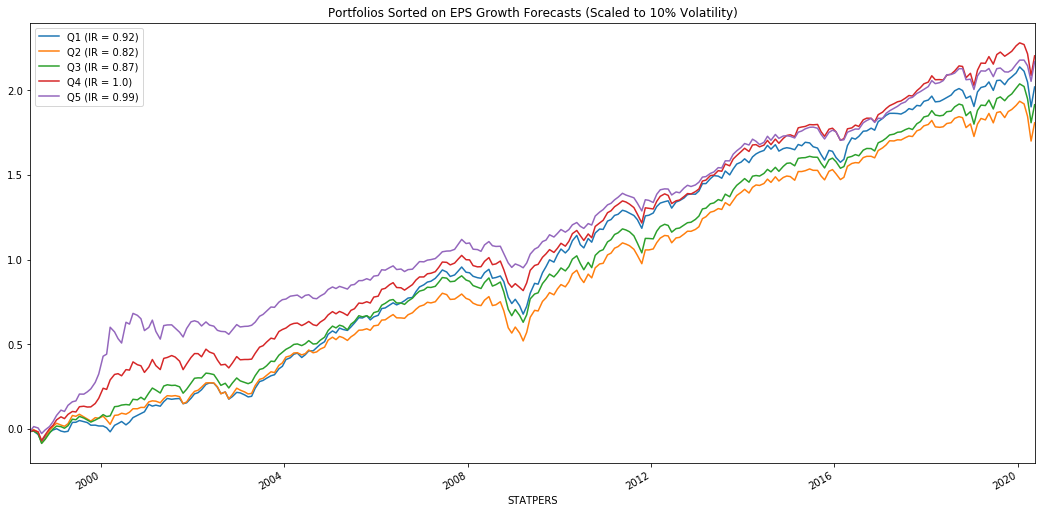

In [26]:
signal = -1*EPS.dropna(how='all', axis=[0, 1])
signal = signal.clip(lower=signal.quantile(0.01, axis=1), upper=signal.quantile(0.99, axis=1), axis=0)
quintiles = signal.apply(lambda x: pd.qcut(x.rank(method='first'), 5, labels=range(5, 0, -1)), axis=1)
#quintiles = quintiles.reindex(monthly_returns.index, method = "pad")
monthly_returns = monthly_returns.reindex(quintiles.index, method = "pad")


quintile_weights = dict()
for q in range(1, 6):
    q_weights = (quintiles == q).astype(int)
    q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
    quintile_weights[q] = q_weights
quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])

quintile_returns = quintile_weights.mul(monthly_returns[monthly_returns.columns.intersection(signal.columns)], axis=0, level=1).sum(axis=1, level=0, min_count=1)
quintile_returns = quintile_returns * (0.10 / (12**0.5 * quintile_returns.std()))
quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])
quintile_returns = quintile_returns * (0.10 / (12**0.5 * quintile_returns.std()))

df = quintile_returns.drop('duration', axis=1)
df.columns = ['Q{i} (IR = {ir})'.format(i=i, ir=np.round(12**0.5 * df[i].mean() / df[i].std(),2)) for i in df.columns]
df.cumsum().plot(title='Portfolios Sorted on EPS Growth Forecasts (Scaled to 10% Volatility)',
                 figsize=(18, 9));

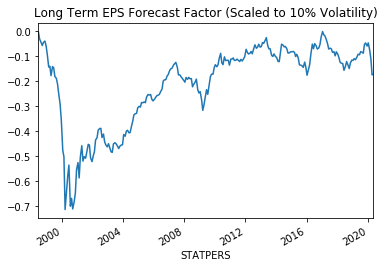

In [27]:
growth_factor = quintile_returns['duration']
growth_factor.cumsum().plot(title='Long Term EPS Forecast Factor (Scaled to 10% Volatility)');

In [28]:
quintile_returns = quintile_weights.mul(monthly_returns[signal.columns], axis=0, level=1).sum(axis=1, level=0, min_count=1)*12
quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])

factors = pd.read_csv("factors.csv", index_col=0)
factors.index = pd.to_datetime(factors.index)
del factors["rf"]
del factors["mktrf"]
factors = factors.resample("M").sum()*12
factors = factors.reindex(quintile_returns.index, method = "pad")
market = monthly_returns[signal.columns].mean(axis=1)
factors["mktrf"] = market*12/1.9

factors = pd.concat((factors,quintile_returns), axis=1, join='inner')
cols = list(factors)
cols.insert(0, cols.pop(cols.index('duration')))
factors = factors.ix[:, cols]

In [29]:
monthly = factors.iloc[24:,]#.resample('M').sum()*12
corr = round(monthly.corr(),3)
corr.style.background_gradient()

,duration,smb,hml,umd,rmw,cma,bab,mktrf,1,2,3,4,5
duration,1,-0.414,0.67,-0.004,0.44,0.572,0.437,-0.235,0.113,-0.01,-0.12,-0.309,-0.582
smb,-0.414,1,-0.12,-0.078,-0.327,-0.139,-0.199,0.432,0.244,0.3,0.355,0.423,0.478
hml,0.67,-0.12,1,-0.054,0.137,0.566,0.234,0.003,0.222,0.155,0.08,-0.07,-0.27
umd,-0.004,-0.078,-0.054,1,0.342,0.288,0.505,-0.409,-0.339,-0.373,-0.369,-0.349,-0.275
rmw,0.44,-0.327,0.137,0.342,1,0.317,0.531,-0.436,-0.227,-0.279,-0.322,-0.402,-0.482
cma,0.572,-0.139,0.566,0.288,0.317,1,0.308,-0.338,-0.111,-0.164,-0.237,-0.351,-0.476
bab,0.437,-0.199,0.234,0.505,0.531,0.308,1,-0.308,-0.099,-0.179,-0.237,-0.327,-0.376
mktrf,-0.235,0.432,0.003,-0.409,-0.436,-0.338,-0.308,1,0.9,0.937,0.955,0.954,0.894
1,0.113,0.244,0.222,-0.339,-0.227,-0.111,-0.099,0.9,1,0.962,0.934,0.875,0.742
2,-0.01,0.3,0.155,-0.373,-0.279,-0.164,-0.179,0.937,0.962,1,0.98,0.933,0.794


In [30]:
quintile_regression_Latex(x_vals=["mktrf", "smb", "hml", "umd"], estimate="duration")

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                 &     Q1    &     Q2    &     Q3    &     Q4    &     Q5    &  duration  \\
\midrule
const            & 0.002     & -0.011    & -0.010    & 0.001     & 0.006     & -0.003     \\
                 & (0.009)   & (0.008)   & (0.008)   & (0.008)   & (0.011)   & (0.014)    \\
mktrf            & 1.150***  & 1.248***  & 1.337***  & 1.252***  & 1.277***  & -0.127**   \\
                 & (0.032)   & (0.030)   & (0.030)   & (0.030)   & (0.038)   & (0.050)    \\
smb              & -0.189*** & -0.146*** & -0.091*** & -0.005    & 0.093**   & -0.282***  \\
                 & (0.031)   & (0.029)   & (0.029)   & (0.028)   & (0.037)   & (0.048)    \\
hml              & 0.201***  & 0.150***  & 0.081***  & -0.079*** & -0.317*** & 0.518***   \\
                 & (0.023)   & (0.021)   & (0.021)   & (0.021)   & (0.027)   & (0.035)    \\
umd              & 0.040***  & 0.023     & 0.027*    & 0.030**   & 0.063***  & -0.

# Cash Flow

In [31]:
data = pd.read_csv("SurvivorshipSloan (2).csv")
data.iloc[:,3:-1] = data.iloc[:,3:-1]*1e6

data["bvps"] = data[["pstk", "pstkl", "pstkrv"]].max(axis=1)
data["be"] = data["seq"] + data["txditc"] - data["bvps"]
data["me"] = data["csho"].mul(data["prcc_f"], fill_value = np.nan)

data["me"][data["me"]<=0.] = np.nan
data["be"][data["be"]<=0.] = np.nan
data["be"][data["be"]>data["me"]*50] = np.nan
data["be"][data["be"]<data["me"]/50] = np.nan
data_clean = data[["fyear", "tic", "me", "be", "ib", "sale"]]
data_clean["date"] = pd.to_datetime(data_clean["fyear"], format='%Y')
data_clean = data_clean.set_index(data_clean["date"])
data_clean.index += datetime.timedelta(days=365 + 90)
del data_clean["date"]
del data_clean["fyear"]

**Industry Specific Values**

In [32]:
industries = returns["gind"].dropna().unique()

In [33]:
a = np.arange(0,len(industries), 1)
b = a[np.arange(len(a))!=37]

In [32]:
dur = []
final = []
for j in industries[b]:
    data = grouped_sectors.get_group(j)["tic"].unique()
    tickers = data_clean.loc[data_clean['tic'].isin(data)]["tic"].unique()
    
    stocks = []
    for i in tickers:
        stocks.append(data_clean.loc[data_clean['tic'].isin(tickers)].where(data_clean.loc[data_clean['tic'].isin(tickers)]["tic"]==i).dropna())

    date_index = data_clean.dropna().index.unique().sort_values()[1:]
    temp =[]
    for i in stocks:
        i = i[~i.index.duplicated()]
        i = i.reindex(date_index)
        if(i.isna().sum().sum()<=37*7):
            i["EG"] = (i["be"] - i["be"].shift()).div(i["be"].shift(), fill_value=np.nan)
            i["ROE"] = (i["ib"]).div(i["be"].shift(), fill_value=np.nan)
            i["SG"] = i["sale"].pct_change(fill_value=np.nan)
            i = i.replace([np.inf, -np.inf], np.nan)
            i.iloc[:,1:] = i.iloc[:,1:].clip(lower=i.iloc[:,1:].quantile(0.01), upper=i.iloc[:,1:].quantile(0.99), axis=1)
            i = i.replace([np.inf, -np.inf], np.nan)
            temp.append(i)

    stocks=temp
    
    ROE_slope = []
    ROE_intercept = []
    ROE_weight = 0.
    EG_slope = []
    EG_intercept = []
    EG_weight = 0.
    for i in stocks:
        try:
            ROE_weight +=len(i["ROE"].dropna())
            model = ARMA(i["ROE"], order=(1,0), missing="drop")
            AR1_res = model.fit()
            ROE_slope.append(AR1_res.params[1]*len(i["ROE"].dropna()))
            ROE_intercept.append(AR1_res.params[0]*len(i["ROE"].dropna()))

            EG_weight +=len(i["SG"].dropna())
            model = ARMA(i["SG"], order=(1,0), missing="drop")
            AR1_res = model.fit()
            EG_slope.append(AR1_res.params[1]*len(i["SG"].dropna()))
            EG_intercept.append(AR1_res.params[0]*len(i["SG"].dropna()))

        except ValueError or LinAlgError: #Not enough observations
            continue


    results = []
    results.append((np.asarray(ROE_slope).sum()/ROE_weight))
    x = max(np.asarray(ROE_intercept).sum()/ROE_weight, 0.)
    x = min(x,0.3)
    results.append(x)
    results.append((np.asarray(EG_slope).sum()/EG_weight))
    x = max(np.asarray(EG_intercept).sum()/EG_weight, 0.)
    x = min(x,0.3)
    results.append(x)
    final.append(results)
    
    temp = SloanDuration(stocks, ROE_coef=results[0], Earnings_coef=results[1], ROE_intercept=results[2], Earnings_intercept=results[3])
    dur.append(temp)

In [34]:
monthly_returns = pd.read_csv("CompustatMonthlyReturns.csv", index_col=0)
market_cap = pd.read_csv("CompustatMonthlyMC.csv", index_col=0)
monthly_returns.index = pd.to_datetime(monthly_returns.index)
market_cap.index = pd.to_datetime(market_cap.index)
monthly_returns[monthly_returns>2.] = 2.

quintiles = market_cap.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
quintiles = quintiles[quintiles<4.]
quintiles[quintiles>0.] = 1.
market_cap = market_cap.mul(quintiles)
market_cap = market_cap.dropna(how='all', axis=[0, 1]).ffill(limit=3)

monthly_returns = monthly_returns[market_cap.columns.intersection(monthly_returns.columns)]
monthly_returns = monthly_returns.reindex(market_cap.index, method = "nearest")

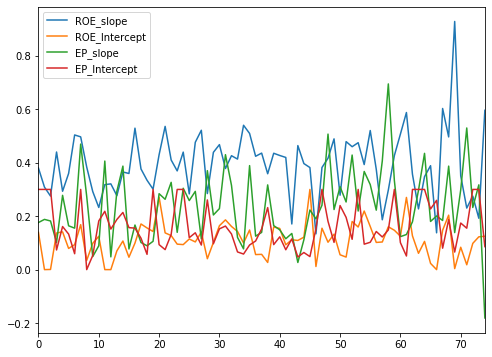

In [123]:
AR  = pd.DataFrame(final, columns=["ROE_slope", "ROE_Intercept", "EP_slope", "EP_Intercept"])
AR.plot(figsize = (8,6));

In [124]:
industries = np.delete(industries, 37)
AR["Code"] = industries
AR = AR.set_index('Code')

GIC = pd.read_csv("GICdictionary.csv", index_col=0)
AR = pd.concat((AR,GIC), axis=1, join='inner')
AR = AR.set_index('Industry')

In [125]:
AR.describe()

,ROE_slope,ROE_Intercept,EP_slope,EP_Intercept
count,70.000000,70.000000,70.000000,70.000000
mean,0.392353,0.114105,0.218835,0.163687
std,0.104546,0.063219,0.118361,0.089071
min,0.133825,0.000000,-0.180928,0.000000
25%,0.324186,0.080369,0.132318,0.093451
50%,0.390942,0.117963,0.211837,0.147175
75%,0.466741,0.147967,0.302931,0.237758
max,0.602858,0.300000,0.469636,0.300000


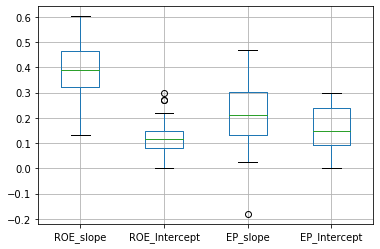

In [126]:
AR.boxplot();

In [36]:
#duration = pd.concat(dur, axis=1).dropna(how='all', axis=[0, 1])
#duration = duration[market_cap.columns.intersection(duration.columns)]
duration = pd.read_csv("SloanDurationSurvivor.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)

duration = duration.resample("M").ffill()
duration = duration.reindex(monthly_returns.index, method = "pad")

In [39]:
#duration = duration.iloc[:110]
#duration = duration.iloc[145:]

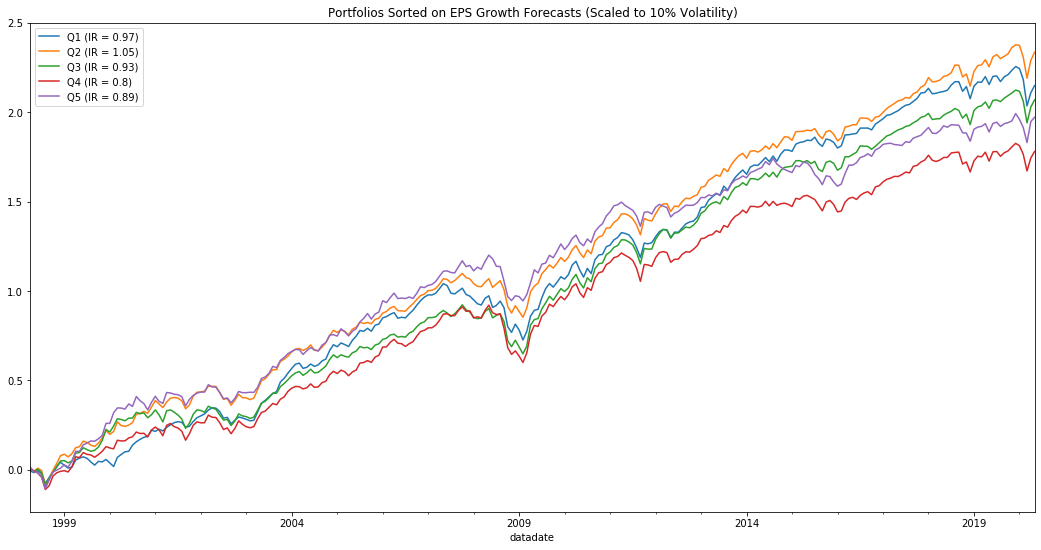

In [38]:
signal = -1*duration.dropna(how='all', axis=[0, 1])
signal = signal.clip(lower=signal.quantile(0.01, axis=1), upper=signal.quantile(0.99, axis=1), axis=0)
quintiles = signal.apply(lambda x: pd.qcut(x.rank(method='first'), 5, labels=range(5, 0, -1)), axis=1)
monthly_returns = monthly_returns.reindex(quintiles.index, method="pad")

quintile_weights = dict()
for q in range(1, 6):
    q_weights = (quintiles == q).astype(int)
    q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
    quintile_weights[q] = q_weights
quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])


quintile_returns = quintile_weights.mul(monthly_returns[monthly_returns.columns.intersection(signal.columns)], axis=0, level=1).sum(axis=1, level=0, min_count=1)
quintile_returns = quintile_returns * (0.10 / (12**0.5 * quintile_returns.std()))
quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])
quintile_returns = quintile_returns * (0.10 / (12**0.5 * quintile_returns.std()))

df = quintile_returns.drop('duration', axis=1)
df.columns = ['Q{i} (IR = {ir})'.format(i=i, ir=np.round(12**0.5 * df[i].mean() / df[i].std(),2)) for i in df.columns]
df.cumsum().plot(title='Portfolios Sorted on EPS Growth Forecasts (Scaled to 10% Volatility)',
                 figsize=(18, 9));

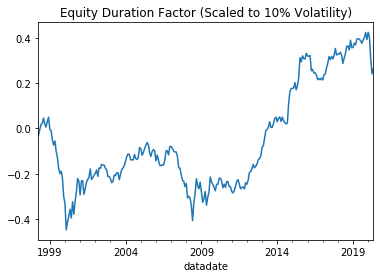

In [39]:
duration_single = quintile_returns['duration']
duration_single.cumsum().plot(title='Equity Duration Factor (Scaled to 10% Volatility)');

In [40]:
quintile_returns = quintile_weights.mul(monthly_returns[monthly_returns.columns.intersection(signal.columns)], axis=0, level=1).sum(axis=1, level=0, min_count=1)*12
quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])

factors = pd.read_csv("factors.csv", index_col=0)
factors.index = pd.to_datetime(factors.index)
del factors["rf"]
del factors["mktrf"]
factors = factors.resample("M").sum()*12
factors = factors.reindex(quintile_returns.index, method = "nearest")
market = monthly_returns[monthly_returns.columns.intersection(signal.columns)].mean(axis=1)
factors["mktrf"] = market*12#/1.75

factors = pd.concat((factors,quintile_returns), axis=1, join='inner')
cols = list(factors)
cols.insert(0, cols.pop(cols.index('duration')))
factors = factors.ix[:, cols]

In [41]:
monthly = factors
corr = round(monthly.corr(),3)
corr.style.background_gradient()

,duration,smb,hml,umd,rmw,cma,bab,mktrf,1,2,3,4,5
duration,1,-0.365,0.352,0.083,0.364,0.43,0.304,-0.469,-0.098,-0.277,-0.323,-0.425,-0.703
smb,-0.365,1,-0.268,0.074,-0.418,-0.249,-0.236,0.377,0.177,0.286,0.311,0.271,0.357
hml,0.352,-0.268,1,-0.163,0.216,0.602,0.314,-0.087,0.201,-0.006,-0.037,0.025,-0.079
umd,0.083,0.074,-0.163,1,0.244,0.147,0.358,-0.349,-0.315,-0.332,-0.358,-0.399,-0.278
rmw,0.364,-0.418,0.216,0.244,1,0.374,0.52,-0.431,-0.219,-0.303,-0.354,-0.354,-0.387
cma,0.43,-0.249,0.602,0.147,0.374,1,0.362,-0.362,-0.069,-0.236,-0.313,-0.294,-0.322
bab,0.304,-0.236,0.314,0.358,0.52,0.362,1,-0.353,-0.099,-0.271,-0.309,-0.254,-0.263
mktrf,-0.469,0.377,-0.087,-0.349,-0.431,-0.362,-0.353,1,0.873,0.947,0.962,0.954,0.921
1,-0.098,0.177,0.201,-0.315,-0.219,-0.069,-0.099,0.873,1,0.933,0.912,0.897,0.776
2,-0.277,0.286,-0.006,-0.332,-0.303,-0.236,-0.271,0.947,0.933,1,0.958,0.933,0.842


In [42]:
quintile_regression_Latex(x_vals=["mktrf", "smb", "hml"], estimate="duration")

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                 &     Q1    &     Q2    &     Q3    &     Q4    &    Q5    &  duration  \\
\midrule
const            & 0.005     & 0.011*    & 0.001     & -0.013**  & 0.002    & 0.004      \\
                 & (0.006)   & (0.006)   & (0.005)   & (0.006)   & (0.008)  & (0.011)    \\
mktrf            & 0.356***  & 0.453***  & 0.493***  & 0.528***  & 0.488*** & -0.132***  \\
                 & (0.010)   & (0.010)   & (0.009)   & (0.010)   & (0.014)  & (0.018)    \\
smb              & -0.067*** & -0.050*** & -0.042*** & -0.068*** & 0.011    & -0.078**   \\
                 & (0.016)   & (0.016)   & (0.015)   & (0.016)   & (0.023)  & (0.031)    \\
hml              & 0.155***  & 0.046***  & 0.028**   & 0.077***  & 0.004    & 0.151***   \\
                 & (0.015)   & (0.015)   & (0.014)   & (0.015)   & (0.021)  & (0.028)    \\
R-squared        & 0.85      & 0.91      & 0.93      & 0.93      & 0.85     & 0.33       \\

# Weber

**EPS Quintiles**

In [43]:
#duration = pd.concat(dur, axis=1).dropna(how='all', axis=[0, 1])
#duration = duration[market_cap.columns.intersection(duration.columns)]

duration = pd.read_csv("SloanDurationSurvivor.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)

EPS = pd.read_csv("SurvivorshipEPS.csv", index_col=0)
EPS.index = pd.to_datetime(EPS.index)
EPS = EPS[EPS.columns.intersection(duration.columns)]
#EPS[EPS>150]=150

In [44]:
EPS.max(axis=1)

STATPERS
1998-01-15    100.00
1998-02-19    100.00
1998-03-19    100.00
1998-04-16    100.00
1998-05-14    100.00
               ...  
2020-01-16    171.50
2020-02-20    281.19
2020-03-19    293.51
2020-04-16    389.46
2020-05-14    282.38
Length: 269, dtype: float64

In [45]:
duration.describe().mean(axis=1)

count     10.684333
mean      64.381580
std      111.259150
min       22.317670
25%       28.997908
50%       34.112786
75%       40.698264
max      343.784943
dtype: float64

In [72]:
def AnalystExpectations(duration, EPS, market_cap,value_weighted=False):
    duration = duration.resample('M').ffill(limit=12)
    
    results = pd.DataFrame(columns=[1,2,3,4,5], index = ['LTG+1','LTG+2','LTG+3','LTG+4','LTG+5'])
    dummy = []
    for i in (1,2,3,4,5):
        EPS_temp = EPS.rolling(window=i*12).mean()
        duration_temp = duration[duration.columns.intersection(EPS_temp.columns)]
        duration_temp = duration_temp.reindex(EPS_temp.index, method = "pad").ffill(limit=12)
        
        market_cap_temp = market_cap.reindex(EPS_temp.index, method = "pad").ffill(limit=12)

        signal = -1*duration_temp.dropna(how='all', axis=[0,1])
        quintiles = signal.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
        quintiles = quintiles.reindex(EPS_temp.index, method = "pad").ffill(limit=12)

        if(value_weighted):
            weights = market_cap_temp[market_cap_temp.columns.intersection(signal.columns)]
            quintile_weights = dict()
            for q in range(1,6):
                q_weights = pd.DataFrame((quintiles == q).astype(int).values*weights.values, columns=weights.columns, index=weights.index)
                q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
                quintile_weights[q] = q_weights
            quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])

        else:
            quintile_weights = dict()
            for q in range(1, 6):
                q_weights = (quintiles == q).astype(int)
                q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
                quintile_weights[q] = q_weights
            quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])



        EPS_temp = quintile_weights.mul(EPS_temp, axis=0, level=1).sum(axis=1, level=0, min_count=1)
        results.iloc[i-1,:] = EPS_temp.median(axis=0)
        dummy.append(EPS_temp)
        
    results = results.rename(columns={1: 'Q1',2: 'Q2',3: 'Q3',4: 'Q4',5: 'Q5'})
    return dummy[4], results

In [73]:
EPS_plot, EPS_quintiles = AnalystExpectations(duration, EPS, market_cap, value_weighted=False)

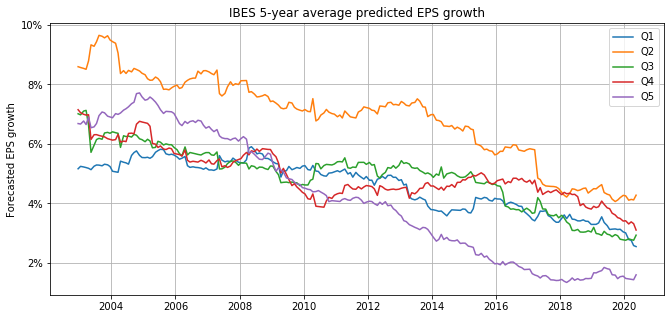

\begin{tabular}{llllll}
\toprule
{} &       Q1 &       Q2 &       Q3 &       Q4 &       Q5 \\
\midrule
LTG+1 &  7.02867 &  9.72761 &  7.97823 &  8.71168 &  8.01914 \\
LTG+2 &  6.25749 &  9.02822 &  7.19768 &  7.67253 &  5.75209 \\
LTG+3 &  5.80602 &  8.39679 &  6.47564 &  6.65306 &  5.15431 \\
LTG+4 &  5.41374 &  7.71982 &  5.72522 &  5.63806 &  4.61859 \\
LTG+5 &  4.91922 &  7.16454 &  5.16073 &  4.69808 &  4.07196 \\
\bottomrule
\end{tabular}



In [74]:
fig = plt.figure(1, (11,5))
ax = fig.add_subplot(1,1,1)
plt.plot(EPS_plot)
plt.legend(EPS_quintiles.columns)
plt.title("IBES 5-year average predicted EPS growth")
plt.ylabel("Forecasted EPS growth")
plt.grid()
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks);
plt.show()

print(EPS_quintiles.to_latex())

**Sentiment**

In [46]:
sentiment = pd.read_csv("sentiment.csv", index_col=0)
sentiment.index = pd.to_datetime(sentiment.index)
sentiment = sentiment.diff()

sentiment[sentiment>0.] = 0.
sentiment[sentiment<0.] = 1.

In [53]:
quintile_returns = quintile_weights.mul(monthly_returns[monthly_returns.columns.intersection(signal.columns)], axis=0, level=1).sum(axis=1, level=0, min_count=1)#*12
quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])

factors = pd.read_csv("factors.csv", index_col=0)
factors.index = pd.to_datetime(factors.index)
del factors["rf"]
del factors["mktrf"]
factors = factors.resample("M").mean()*12
factors = factors.reindex(quintile_returns.index, method = "pad")
market = monthly_returns[monthly_returns.columns.intersection(signal.columns)].mean(axis=1)
factors["mktrf"] = market#*48

factors = pd.concat((factors,quintile_returns), axis=1, join='inner')
cols = list(factors)
cols.insert(0, cols.pop(cols.index('duration')))
monthly = factors.ix[:, cols]

monthly["high"] = sentiment["SENT1"]
quintile_monthly = quintile_returns.resample("M").mean()*12
quintile_monthly = quintile_monthly.reindex(monthly.index)

In [54]:
Weber_regression(["high","mktrf"], estimate="duration")


                    Q1       Q2       Q3       Q4       Q5     duration
-----------------------------------------------------------------------
const            0.014    0.016*   0.009    -0.014   0.013    0.001    
                 (0.011)  (0.008)  (0.008)  (0.010)  (0.012)  (0.017)  
high             0.005    -0.001   -0.009   0.009    -0.021   0.026    
                 (0.015)  (0.012)  (0.011)  (0.013)  (0.017)  (0.024)  
mktrf            3.696*** 4.992*** 5.585*** 6.042*** 5.705*** -2.010***
                 (0.145)  (0.114)  (0.109)  (0.131)  (0.163)  (0.237)  
R-squared        0.73     0.89     0.92     0.90     0.84     0.24     
No. observations 248      248      248      248      248      248      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Fama-MacBeth

In [55]:
BM = pd.read_csv("BMSurvivor.csv", index_col=0)
BM = BM[duration.columns.intersection(BM.columns)]
BM.index = pd.to_datetime(BM.index)
duration = duration[duration.columns.intersection(BM.columns)]

In [69]:
value_LS = LSfactor9(BM)
duration_LS = LSfactor9(-1*duration)
duration_value = doubleSortFactor(-1*duration, BM)
value_duration = doubleSortFactor(BM, -1*duration)

In [70]:
valueVSduration = pd.concat((duration_LS,value_duration,value_LS,duration_value), axis=1)
valueVSduration = valueVSduration.rename(columns={0: 'duration',1: 'duration (BM-neutral)',2: 'BM',3: 'BM (duration-neutral)'})
valueVSduration = valueVSduration * (0.10 / (260**0.5 * valueVSduration.std()))
valueVSduration = valueVSduration.resample("M").mean()*12

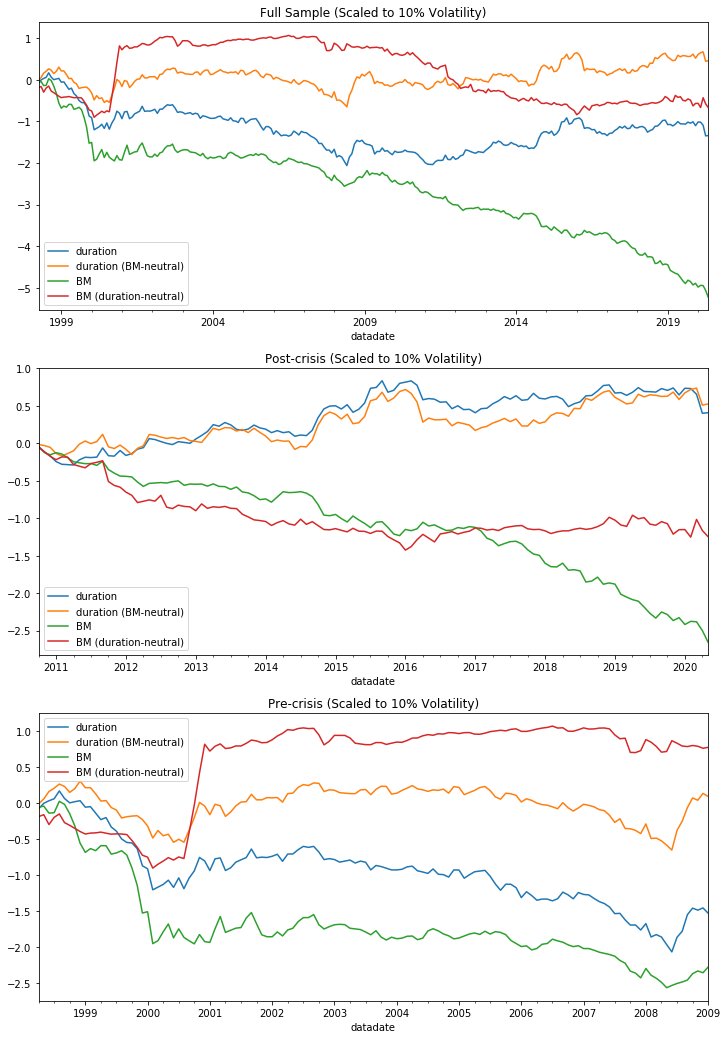

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (12,18))

valueVSduration.cumsum().plot(ax=axes[0], title = "Full Sample (Scaled to 10% Volatility)");
valueVSduration.iloc[150:,].cumsum().plot(ax=axes[1],  title = "Post-crisis (Scaled to 10% Volatility)");
valueVSduration.iloc[:130,].cumsum().plot(ax=axes[2],  title = "Pre-crisis (Scaled to 10% Volatility)");

In [104]:
monthly_returns = pd.read_csv("CompustatMonthlyReturns.csv", index_col=0)
market_cap = pd.read_csv("CompustatMonthlyMC.csv", index_col=0)
monthly_returns.index = pd.to_datetime(monthly_returns.index)
market_cap.index = pd.to_datetime(market_cap.index)
monthly_returns[monthly_returns>2.] = 2.
monthly_returns = monthly_returns*12

quintiles = market_cap.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
quintiles = quintiles[quintiles<4.]
quintiles[quintiles>0.] = 1.
market_cap = market_cap.mul(quintiles)
market_cap = market_cap.dropna(how='all', axis=[0, 1]).ffill(limit=3)

monthly_returns = monthly_returns[market_cap.columns.intersection(monthly_returns.columns)]
monthly_returns = monthly_returns.reindex(market_cap.index, method = "nearest")

factors = pd.read_csv("factors.csv", index_col=0)
factors.index = pd.to_datetime(factors.index)
del factors["rf"]
#del factors["mktrf"]
factors = factors.resample("M").sum()*12
#factors = factors.reindex(quintile_returns.index, method = "nearest")
#market = monthly_returns[monthly_returns.columns.intersection(signal.columns)].mean(axis=1)
#factors["mktrf"] = market #*12#/1.75

In [105]:
CAPM_betas = pd.DataFrame(index=monthly_returns.index, columns= monthly_returns.columns)

for i in CAPM_betas.columns:
    CAPM_betas[i] = (monthly_returns[i].rolling(48, min_periods=12).corr(factors["mktrf"], pairwise = True)/factors["mktrf"].rolling(48, min_periods=12).std())*monthly_returns[i].rolling(48, min_periods=12).std()

In [106]:
signal = CAPM_betas.resample("4A").mean().reindex(monthly_returns.index, method = "nearest").dropna(how='all', axis=[0, 1])
signal = signal.clip(lower=signal.quantile(0.01, axis=1), upper=signal.quantile(0.99, axis=1), axis=0)
portfolios = signal.apply(lambda x: pd.qcut(x.rank(method='first'), 20, labels=range(20, 0, -1)), axis=1)

portfolio_weights = dict()
for q in range(1, 21):
    q_weights = (portfolios == q).astype(int)
    q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
    portfolio_weights[q] = q_weights.resample('B').ffill(limit=7)
portfolio_weights = pd.concat(portfolio_weights, axis=1).dropna(how='all', axis=[0, 1])

beta_portfolios = portfolio_weights.mul(monthly_returns[signal.columns], axis=0, level=1).sum(axis=1, level=0, min_count=1)
beta_portfolios = beta_portfolios.dropna(how='all', axis=[0, 1])

In [107]:
factors["duration_LS"] = duration_LS.reindex(monthly_returns.index, method = "nearest")
factors["value_LS"] = value_LS.reindex(monthly_returns.index, method = "nearest")
factors["duration_neutral"] = value_duration.reindex(monthly_returns.index, method = "nearest")
factors["value_neutral"] = duration_value.reindex(monthly_returns.index, method = "nearest")

In [108]:
periods = 2

In [109]:
FamaMacBeth_NPeriod(beta_portfolios, factors[["mktrf", "duration_LS"]], N=periods, GLS=False, NW=False)

,mktrf,duration_LS,intercept
Risk Premium,72.87,-4.69,68.02
t,0.84,-0.72,3.58
Risk Premium,50.66,-1.11,52.68
t,0.73,-0.34,2.51


In [110]:
FamaMacBeth_NPeriod(beta_portfolios, factors[["mktrf", "value_LS"]], N=periods, GLS=False, NW=False)

,mktrf,value_LS,intercept
Risk Premium,89.69,-3.50,62.74
t,1.02,-0.82,3.20
Risk Premium,62.79,-4.90,52.87
t,0.90,-1.51,2.43


In [111]:
FamaMacBeth_NPeriod(beta_portfolios, factors[["mktrf", "value_LS", "duration_LS"]], N=periods, GLS=True, NW=False)

,mktrf,value_LS,duration_LS,intercept
Risk Premium,30.42,-0.13,-10.98,81.62
t,2.88,-0.03,-0.99,3.05
Risk Premium,24.31,-4.54,-3.64,67.63
t,2.55,-1.13,-0.48,2.70


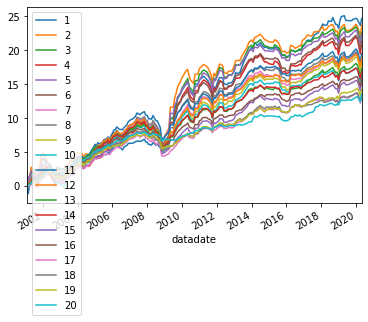

In [112]:
beta_portfolios.cumsum().plot()